# Table of Content

- [Preparing data for modeling](#prepare)
- [Modeling](#model)
- [Best Features Selection](#fea)
- [Handling Class Imbalance](#imbalance)
- [Hyperparameter Tunning](#tuning)
- [Define Preprocessing Function](#function)
- [Performance Evaluation](#eval)
- [Save Final Model trained on Full data](#train)

<a id=prepare><a />
# Preparing data for modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from Functions import my_funcs_prep as my

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('../02_Data/Working/df_train_prep.csv')
empleo_features = pd.read_csv('../02_Data/Working/empleo_features.csv')

df_train.shape, empleo_features.shape

((159802, 44), (159802, 68))

In [3]:
y_train = df_train.default
X_train = df_train.drop(columns=['default'])

new_vars = ["antigüedad_empleo_num", "cancelaciones_12meses_bin", "derogatorios_bin"]
orig_vars = X_train.columns.difference(new_vars).tolist()

len(new_vars), len(orig_vars)

(3, 40)

In [4]:
# X_train with original variables (excluding employment):
X_train_orig = X_train[orig_vars]

# X_train + derived variables (excluding employment):
X_train_new = X_train[orig_vars + new_vars]

# X_train + employment features (46 columns):
X_train_all = X_train_new.join(empleo_features)

X_train_orig.shape, X_train_new.shape, X_train_all.shape

((159802, 40), (159802, 43), (159802, 111))

<a id=model><a />
# Modeling

## ML Model Selection

In [12]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

# Instantiate the models with default hyperparameters:
gaussian_nb    = GaussianNB()
logreg         = LogisticRegression(n_jobs=-1, random_state=0)
rfc            = RandomForestClassifier(n_jobs=-1, random_state=0)
lgbmc          = LGBMClassifier(objective='binary', verbose=-1, n_jobs=-1, random_state=0)

# Save in tuples:
modelos = [
    ('GaussianNB', gaussian_nb),
    ('LogisticRegression', logreg),
    ('LGBMClassifier', lgbmc),
    ('RandomForestClassifier', rfc)
]

# Ensuring each fold is representative of the training set
# due to the class imbalance in y:
kfold_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Cross-validation and results of each model:
for name, model in modelos:
    dict_cv = cross_validate(
        estimator=model,
        X=X_train_all,  # with all features!
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )
    print(
        f"\033[1m{name.ljust(23)}\033[0m",                                                                 
        f": fit_time={np.mean(dict_cv['fit_time']):.2f}s",                                               
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.3f} ({np.std(dict_cv['test_accuracy']):.3f})",                                                               
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.3f} ({np.std(dict_cv['test_roc_auc']):.3f})",     
        f"| f1={np.mean(dict_cv['test_f1']):.3f} ({np.std(dict_cv['test_f1']):.3f})",                      
        f"| precision={np.mean(dict_cv['test_precision']):.3f} ({np.std(dict_cv['test_precision']):.3f})",
        f"| recall={np.mean(dict_cv['test_recall']):.3f} ({np.std(dict_cv['test_recall']):.3f})",                 
    )
    print()

GaussianNB              : fit_time=1.00s | accuracy=0.867 (0.001) | roc_auc=0.661 (0.008) | f1=0.039 (0.023) | precision=0.243 (0.053) | recall=0.021 (0.014)

LogisticRegression      : fit_time=8.62s | accuracy=0.872 (0.000) | roc_auc=0.521 (0.007) | f1=0.000 (0.000) | precision=0.025 (0.075) | recall=0.000 (0.000)

LGBMClassifier          : fit_time=6.05s | accuracy=0.872 (0.000) | roc_auc=0.723 (0.003) | f1=0.007 (0.001) | precision=0.518 (0.157) | recall=0.004 (0.001)

RandomForestClassifier  : fit_time=86.61s | accuracy=0.872 (0.000) | roc_auc=0.684 (0.003) | f1=0.021 (0.003) | precision=0.505 (0.082) | recall=0.011 (0.001)



In [8]:
y_train.value_counts(normalize=True)

default
0    0.871948
1    0.128052
Name: proportion, dtype: float64

Observations:
- Using 5 classification metrics to establish a more comprehensive comparison framework, it is observed that **LightGBM is the best model in terms of ROC AUC with 0.72**, with a much faster training time than Random Forest with 0.68 (6s < 86s)!

- **Looking into the specific metrics for the positive class (1), f1, precision, and recall, very low f1 scores are observed in all models, which is expected given the few default data**. The Naïve Bayes model produces a better f1 score of 0.023 > 0.007 than LGBM but with a lower roc_auc of 0.66 < 0.723, indicating that it relatively classifies worse than LGBM. We will not consider Random Forest for now, as it takes a long time to train and therefore we will not be able to iterate multiple times.

- For now, **we will stick with the LGBM model**.


## Compare Models with different set of Features

In [13]:
for train_set in [X_train_orig, X_train_new, X_train_all]:
    dict_cv = cross_validate(
        estimator=lgbmc,
        X=train_set, 
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )
    print(
        f"\033[1m{lgbmc.__class__.__name__.ljust(10)}\033[0m",                                                                 
        f": shape={train_set.shape}",                                                                                                             
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.3f} ({np.std(dict_cv['test_accuracy']):.3f})",     
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.3f} ({np.std(dict_cv['test_roc_auc']):.3f})",     
        f"| f1={np.mean(dict_cv['test_f1']):.3f} ({np.std(dict_cv['test_f1']):.3f})",                      
        f"| precision={np.mean(dict_cv['test_precision']):.3f} ({np.std(dict_cv['test_precision']):.3f})",
        f"| recall={np.mean(dict_cv['test_recall']):.3f} ({np.std(dict_cv['test_recall']):.3f})",                 
    )
    print()

LGBMClassifier : shape=(159802, 40) | accuracy=0.872 (0.000) | roc_auc=0.722 (0.004) | f1=0.008 (0.002) | precision=0.484 (0.101) | recall=0.004 (0.001)

LGBMClassifier : shape=(159802, 43) | accuracy=0.872 (0.000) | roc_auc=0.722 (0.004) | f1=0.008 (0.003) | precision=0.472 (0.135) | recall=0.004 (0.001)

LGBMClassifier : shape=(159802, 111) | accuracy=0.872 (0.000) | roc_auc=0.723 (0.003) | f1=0.007 (0.001) | precision=0.518 (0.157) | recall=0.004 (0.001)



Observations:
- According to the results of the same model on different subsets of increasing features, **no improvements in model performance are observed by adding derived variables**: the metrics using the original variables (without `employment`) are superior to those in the models where they were incorporated. **Instead, the incorporation of these new variables has added noise to the model**! The inclusion of the employment columns has slightly increased the metrics in roc_auc from 0.722 to 0.723. In my opinion, *this slight increase is not enough to justify keeping 68 additional variables*!

- I decide to use the original variables going forward: `X_train_orig`.


<a id=fea><a />
# Best Features Selection

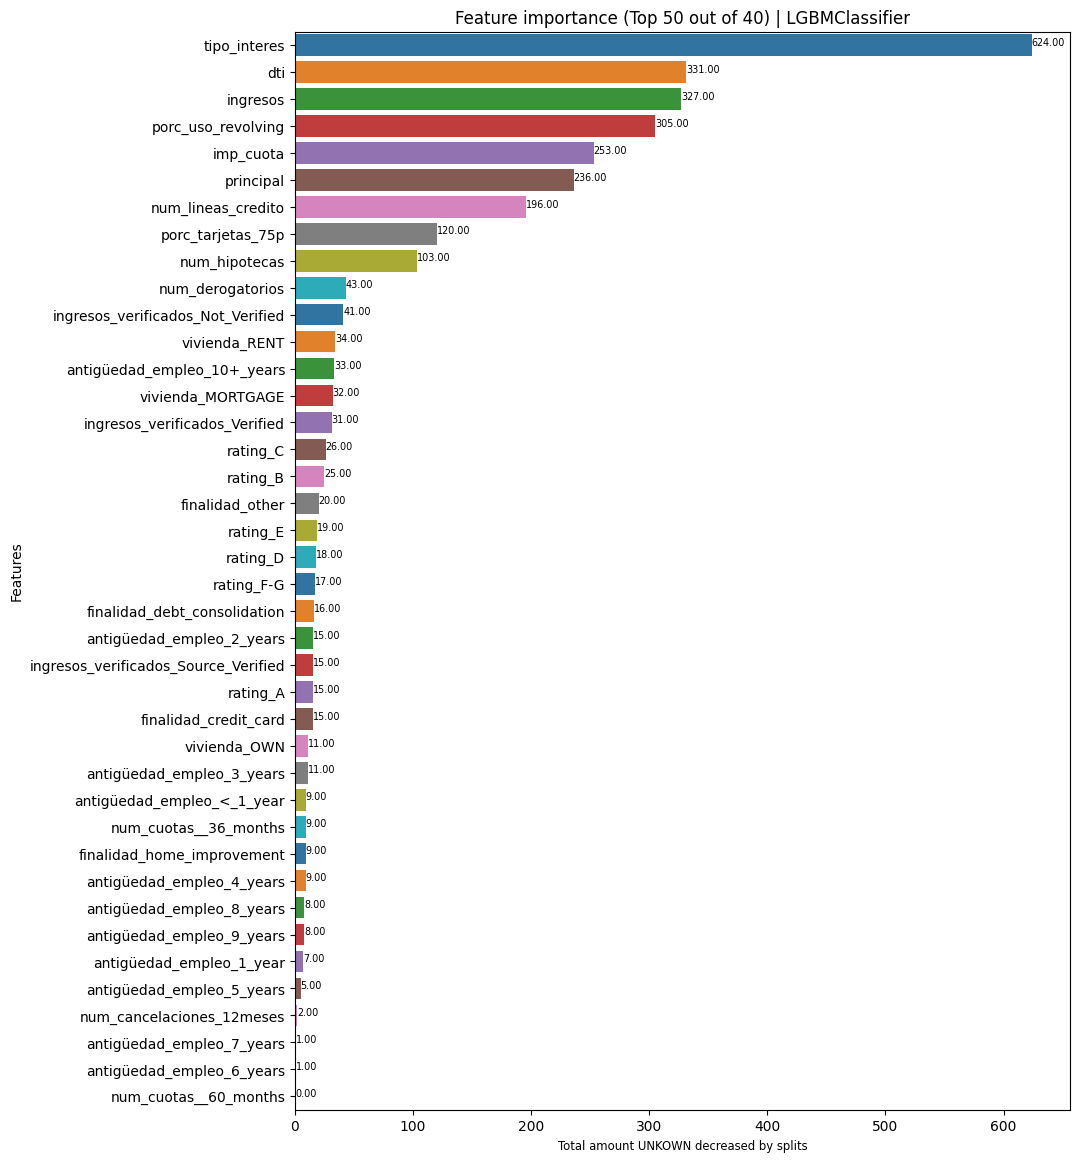

In [6]:
lgbmc.fit(X_train_orig, y_train)

# Mostrar las 50 variables más relevantes en la predicción (LGBM):
my.feature_importance_plot(
    tree_predictor=lgbmc,
    n_rows=50,
    figsize=(10, 14)
)

<Axes: >

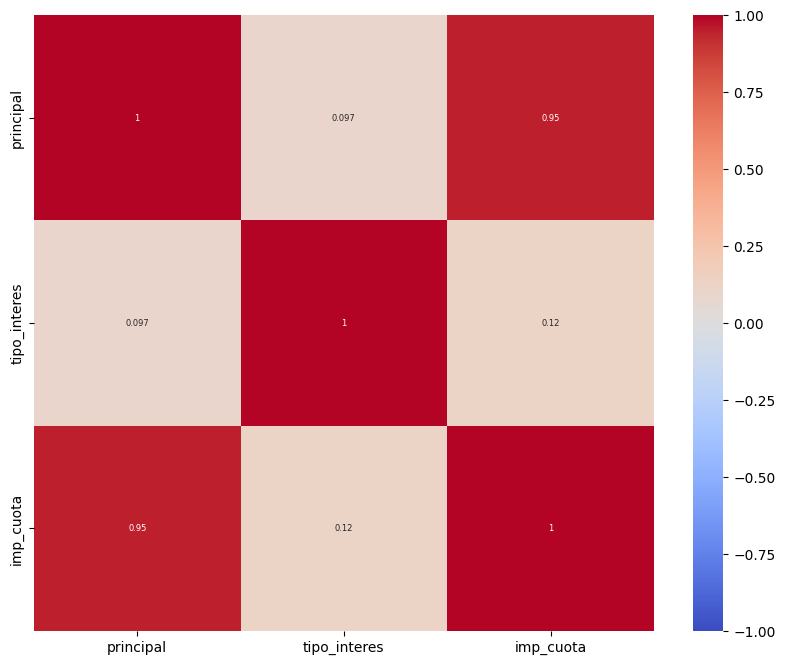

In [15]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    X_train_orig[['principal', 'tipo_interes', 'imp_cuota']].corr(),
    annot=True,
    annot_kws={"fontsize": 6},
    cmap='coolwarm',
    vmin=-1, vmax=1
)

In [7]:
# TODO: eliminar imp_cuota por desconocer su proceso de generacion.
X_train_orig.drop(columns='imp_cuota', inplace=True)

Observations:
- The plot of variable importance suggests that the **10 most predictive variables**, at a multivariate level, are as follows:
    1. `interest_rate`.
    2. `principal`.
    3. `installment`: it is **highly correlated with `principal`**, which makes sense. We will check removing this variable to evaluate it. It may be capturing additional information by interacting with the rest of the variables!
    4. `income`.
    5. `dti`.
    6. `term`.
    7. `credit_rating`.
    8. `num_credit_lines`.
    9. `perc_utilization_75p`.

- **Many of these variables are related to credit history and are collectible only for veteran borrowers (in my opinion)** and not for new customers:
    - `dti`: In many cases, *the debts of new customers are not known*.
    - `credit_rating`: It is based on the financial and credit history of an individual or entity. *For new customers, there may not be enough information to calculate a credit rating*.
    - `num_credit_lines` and `perc_utilization_75p`, `perc_revolving_utilization`: In this case, *we do not know if these are credit lines / credit cards issued by the lending financial institution or also include those issued by other entities*.
    - `installment`: It is not the result of applying `Monthly payment = (P * i) / (1 - (1 + i) ^ (-n)`. It may have been calculated using another formula or taking other factors into account. Therefore, **we will discard it for production purposes as we will not be able to generate it**.


In [8]:
mask_rating = X_train_orig.columns.str.contains('rating_')
rating_list = X_train_orig.columns[mask_rating].tolist()
rating_list

['rating_A', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F-G']

In [11]:
X_train_nuevos_clientes = X_train_orig.drop(columns=rating_list + [
    'dti', 'num_lineas_credito', 'porc_tarjetas_75p', 'porc_uso_revolving'
])

for train_set in [X_train_orig, X_train_nuevos_clientes]:
    dict_cv = cross_validate(
        estimator=lgbmc,
        X=train_set, 
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )
    print(
        f"\033[1m{lgbmc.__class__.__name__.ljust(10)}\033[0m",                                                                 
        f": shape={train_set.shape}",                                                                                                             
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.3f} ({np.std(dict_cv['test_accuracy']):.3f})",     
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.3f} ({np.std(dict_cv['test_roc_auc']):.3f})",     
        f"| f1={np.mean(dict_cv['test_f1']):.3f} ({np.std(dict_cv['test_f1']):.3f})",                      
        f"| precision={np.mean(dict_cv['test_precision']):.3f} ({np.std(dict_cv['test_precision']):.3f})",
        f"| recall={np.mean(dict_cv['test_recall']):.3f} ({np.std(dict_cv['test_recall']):.3f})",                 
    )
    print()

LGBMClassifier : shape=(159802, 39) | accuracy=0.872 (0.000) | roc_auc=0.721 (0.004) | f1=0.009 (0.004) | precision=0.455 (0.162) | recall=0.004 (0.002)

LGBMClassifier : shape=(159802, 29) | accuracy=0.872 (0.000) | roc_auc=0.716 (0.004) | f1=0.001 (0.001) | precision=0.543 (0.234) | recall=0.001 (0.000)



Observations:
- The **prediction model for new customers** has 10 fewer variables (5 of them are dummies of `credit_rating`) and, as expected (including a couple of predictive variables within), **performs worse than the model with information from borrowers' credit history**. The roc_auc of the model open to new customers has a roc_auc of 0.716 compared to 0.721 for the model with credit history information.

- Knowing that our model predicts the minority class, defaults, poorly with an f1 score below 0.01, I believe it would be **more convenient to exclude new customers and focus only on those customers for whom we have credit history information**, using predictive variables such as `dti`, `perc_revolving_utilization`, `perc_utilization_75p`, among others. *We hope to have, at least, a decent model for default detection using the variables we have related to borrowers' credit history*.


In [12]:
lgbmc.fit(X_train_orig, y_train)

# Mejores variables para el modelo inclusivo:
df_bestfeats = my.feature_importance_plot(
    tree_predictor=lgbmc,
    return_df=True
)

df_bestfeats

,feature_importance
tipo_interes,648
principal,351
ingresos,346
dti,345
porc_uso_revolving,322
num_lineas_credito,213
porc_tarjetas_75p,121
num_hipotecas,98
ingresos_verificados_Not_Verified,46
ingresos_verificados_Verified,41


In [13]:
# TODO: Change column names. Column name 'num_cuotas' produced by LGBM 
#(no spaces allowed, replaced by '_') differs from the original.
X_train.rename(columns={
    'num_cuotas_ 36 months': 'num_cuotas__36_months',
    'num_cuotas_ 60 months': 'num_cuotas__60_months',
    'antigüedad_empleo_1 year': 'antigüedad_empleo_1_year',
    'antigüedad_empleo_10+ years': 'antigüedad_empleo_10+_years',
    'antigüedad_empleo_2 years': 'antigüedad_empleo_2_years',
    'antigüedad_empleo_3 years': 'antigüedad_empleo_3_years',
    'antigüedad_empleo_4 years': 'antigüedad_empleo_4_years',
    'antigüedad_empleo_5 years': 'antigüedad_empleo_5_years',
    'antigüedad_empleo_6 years': 'antigüedad_empleo_6_years',
    'antigüedad_empleo_7 years': 'antigüedad_empleo_7_years',
    'antigüedad_empleo_8 years': 'antigüedad_empleo_8_years',
    'antigüedad_empleo_9 years': 'antigüedad_empleo_9_years',
    'antigüedad_empleo_< 1 year': 'antigüedad_empleo_<_1_year',
    'ingresos_verificados_Not Verified': 'ingresos_verificados_Not_Verified',
    'ingresos_verificados_Source Verified': 'ingresos_verificados_Source_Verified',
}, inplace=True)

In [18]:
# Create many feature subsets with the most predictive variables:
X_best5 = X_train[list(df_bestfeats.index[:5])]
X_best10 = X_train[list(df_bestfeats.index[:10])]
X_best15 = X_train[list(df_bestfeats.index[:15])]
X_best20 = X_train[list(df_bestfeats.index[:20])]
X_best25 = X_train[list(df_bestfeats.index[:25])]
X_best30 = X_train[list(df_bestfeats.index[:30])]
X_best35 = X_train[list(df_bestfeats.index[:35])]
X_best_all = X_train[list(df_bestfeats.index[:40])]

lista_Xs = [X_best5, X_best10, X_best15, X_best20, X_best25, X_best30, X_best35, X_best_all]
for train_set in lista_Xs:
    dict_cv = cross_validate(
        estimator=lgbmc,
        X=train_set, 
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )
    print(
        f"\033[1m{lgbmc.__class__.__name__.ljust(10)}\033[0m",                                                                 
        f": shape={train_set.shape}",                                                                                                             
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.3f} ({np.std(dict_cv['test_accuracy']):.3f})",     
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.3f} ({np.std(dict_cv['test_roc_auc']):.3f})",     
        f"| f1={np.mean(dict_cv['test_f1']):.3f} ({np.std(dict_cv['test_f1']):.3f})",                      
        f"| precision={np.mean(dict_cv['test_precision']):.3f} ({np.std(dict_cv['test_precision']):.3f})",
        f"| recall={np.mean(dict_cv['test_recall']):.3f} ({np.std(dict_cv['test_recall']):.3f})",                 
    )
    print()

LGBMClassifier : shape=(159802, 5) | accuracy=0.872 (0.000) | roc_auc=0.715 (0.005) | f1=0.001 (0.001) | precision=0.298 (0.188) | recall=0.001 (0.000)

LGBMClassifier : shape=(159802, 10) | accuracy=0.872 (0.000) | roc_auc=0.714 (0.004) | f1=0.001 (0.001) | precision=0.464 (0.340) | recall=0.001 (0.001)

LGBMClassifier : shape=(159802, 15) | accuracy=0.872 (0.000) | roc_auc=0.719 (0.004) | f1=0.007 (0.003) | precision=0.492 (0.133) | recall=0.004 (0.002)

LGBMClassifier : shape=(159802, 20) | accuracy=0.872 (0.000) | roc_auc=0.722 (0.004) | f1=0.006 (0.003) | precision=0.427 (0.122) | recall=0.003 (0.001)

LGBMClassifier : shape=(159802, 25) | accuracy=0.872 (0.000) | roc_auc=0.723 (0.003) | f1=0.012 (0.003) | precision=0.529 (0.098) | recall=0.006 (0.002)

LGBMClassifier : shape=(159802, 30) | accuracy=0.872 (0.000) | roc_auc=0.722 (0.003) | f1=0.011 (0.004) | precision=0.497 (0.102) | recall=0.005 (0.002)

LGBMClassifier : shape=(159802, 35) | accuracy=0.872 (0.000) | roc_auc=0.722 

In [41]:
import joblib

# Guardamos las variables finales:
vars_final = sorted(X_best25.columns)

joblib.dump(value=vars_final, filename='../06_Other/final_variables')

['../06_Other/final_variables']

Observations:
- We compare the results of different feature subsets ordered based on their predictive power against y.

- These results suggest, based on the principle of parsimony as well, **that beyond the top 25 predictors, the model performance starts to degrade** due to the noise added by irrelevant features to the model.

- Based on the above criterion, **we choose the subset with the top 25 predictors** with a roc_auc of 0.723, and f1 score of 0.012!


<a id=imbalance><a />
# Handling Class Imbalance

In [143]:
y_train.value_counts(normalize=False)

default
0    139339
1     20463
Name: count, dtype: int64

## RUS + SMOTE

In [22]:
from imblearn.under_sampling import RandomUnderSampler

# reduce mayority class to 0.5 * original.
rus = RandomUnderSampler(random_state=0, sampling_strategy=20463/np.round(0.5*139339))
X_best25_rus, y_train_rus = rus.fit_resample(X_best25, y_train)

y_train_rus.value_counts()

default
0    69670
1    20463
Name: count, dtype: int64

In [25]:
from imblearn.over_sampling import SMOTE
# Increase minority class to 1.5 * original.
smote = SMOTE(random_state=0, sampling_strategy=np.round((20463*2))/69670)
X_best25_rus_smote, y_train_rus_smote = smote.fit_resample(X_best25_rus, y_train_rus)

y_train_rus_smote.value_counts()

default
0    69670
1    40926
Name: count, dtype: int64

## Class Weights

In [26]:
# Applying class weight does not alter the original dataset, avoiding the introduction of synthetic data.
lgbmc_cw = LGBMClassifier(
    objective='binary',
    class_weight='balanced',  # We balance by adjusting the class weights.
    verbose=-1,
    random_state=0
)

lgbmc_cw

LGBMClassifier(class_weight='balanced', objective='binary', random_state=0,
               verbose=-1)

In [27]:
# Creamos tuplas:
tuplas = [
    ("LGBMClassifier_rus_smote", lgbmc, X_best25_rus_smote, y_train_rus_smote),
    ("LGBMClassifier_cw", lgbmc_cw, X_best25, y_train)
]

for name, model, X_train, y_train in tuplas:
    dict_cv = cross_validate(
        estimator=model,
        X=X_train, # We use the subset with the top 25 predictors.
        y=y_train,
        scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'],
        cv=kfold_strat,
        n_jobs=-1,
        verbose=0,        
    )

    print(
        f"\033[1m{name.ljust(25)}\033[0m",                                                                 
        f": shape={X_train.shape}",                                                                
        f"| accuracy={np.mean(dict_cv['test_accuracy']):.3f} ({np.std(dict_cv['test_accuracy']):.3f})",                                               
        f"| roc_auc={np.mean(dict_cv['test_roc_auc']):.3f} ({np.std(dict_cv['test_roc_auc']):.3f})",     
        f"| f1={np.mean(dict_cv['test_f1']):.3f} ({np.std(dict_cv['test_f1']):.3f})",                      
        f"| precision={np.mean(dict_cv['test_precision']):.3f} ({np.std(dict_cv['test_precision']):.3f})",
        f"| recall={np.mean(dict_cv['test_recall']):.3f} ({np.std(dict_cv['test_recall']):.3f})",                 
    )
    print()

LGBMClassifier_rus_smote  : shape=(110596, 25) | accuracy=0.819 (0.003) | roc_auc=0.859 (0.003) | f1=0.692 (0.007) | precision=0.930 (0.004) | recall=0.551 (0.008)

LGBMClassifier_cw         : shape=(159802, 25) | accuracy=0.647 (0.003) | roc_auc=0.725 (0.003) | f1=0.334 (0.004) | precision=0.220 (0.003) | recall=0.691 (0.009)



Observations:
- At first glance, it seems that the combined resampling technique of RUS & SMOTE generates better results with a roc_auc of 0.859 > 0.725. However, we cannot rely too much on cross-validation since, in addition to reducing **the sample in the majority class, we have created '20463*2' synthetic samples of the minority class with SMOTE**. The result is subject to generalization bias and overfitting.

- Regarding **the class weights adjustment technique, it is much simpler to implement and does not generate synthetic samples**. With LGBM, balancing the class weights has achieved an *increase in recall for the positive class from 0.006 to 0.691* although with its inevitable loss of precision and accuracy (increase in false positives).
- Therefore, **we will evaluate it in the Performance Evaluation section**.


<a id=tuning><a />
# Hyperparameter Tunning

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

lgbmc_cw = LGBMClassifier(
    objective='binary',
    verbose=-1,
    random_state=0,
    class_weight='balanced'
)

param_grid_lgbmc = {
    'learning_rate': np.linspace(0.01, 0.1, 20),  # step size shrinkage.
    'n_estimators': [100, 150, 200],      # number of boosted trees to fit.
}

kfold_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rd_search_lgbmc = RandomizedSearchCV(
    estimator=lgbmc_cw,
    param_distributions=param_grid_lgbmc,
    n_iter=50,  # Change this!
    scoring='roc_auc',
    n_jobs=-1,
    refit=True,
    cv=kfold_strat,
    verbose=1,
)

# Entrenar los 50 modelos aleatorios (250 fits):
rd_search_lgbmc.fit(X_best25, y_train)

# Generar df de los resultados ordenados por ranking de mean roc_auc:
df_rd_search_lgbmc = pd.DataFrame(data=rd_search_lgbmc.cv_results_)[[
    'param_learning_rate', 'param_n_estimators',
    'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time'
]]
df_rd_search_lgbmc = df_rd_search_lgbmc.sort_values('rank_test_score')
df_rd_search_lgbmc

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_fit_time
12,0.028947,200,0.724746,0.002611,1,67.382458
17,0.043158,150,0.724697,0.002317,2,48.694053
14,0.033684,200,0.724684,0.002639,3,69.082933
6,0.052632,100,0.724607,0.002472,4,32.521449
23,0.038421,150,0.724572,0.002623,5,49.099674
11,0.047895,150,0.724547,0.002747,6,53.601740
33,0.066842,100,0.724546,0.002689,7,39.680203
3,0.033684,150,0.724522,0.002879,8,6.891841
22,0.043158,200,0.724503,0.002248,9,62.625844
19,0.062105,100,0.724495,0.003226,10,31.933148


Observations:
- From the search of 50 parameter combinations, **the best one results in a roc_auc of 0.725**, which is the same as the model with default parameters.
- Given this, **we will proceed with the model using default parameters with balanced class weights**.


<a id=function><a />
# Define Preprocessing Function

In [57]:
best25_list = [
    'antigüedad_empleo_10+_years',
    'antigüedad_empleo_2_years',
    'antigüedad_empleo_3_years',
    'dti',
    'finalidad_debt_consolidation',
    'finalidad_other',
    'ingresos',
    'ingresos_verificados_Not_Verified',
    'ingresos_verificados_Source_Verified',
    'ingresos_verificados_Verified',
    'num_derogatorios',
    'num_hipotecas',
    'num_lineas_credito',
    'porc_tarjetas_75p',
    'porc_uso_revolving',
    'principal',
    'rating_A',
    'rating_B',
    'rating_C',
    'rating_D',
    'rating_E',
    'rating_F-G',
    'tipo_interes',
    'vivienda_MORTGAGE',
    'vivienda_RENT'
]

def impute_missing(df_train, X_test):
    # Evitar sobreescribir variable.
    df_train = df_train.copy()
    X_test = X_test.copy()

    # Eliminar registros del conjunto de entrenamiento.
    mask_zero_notVerified = (df_train.ingresos == 0) & (df_train.ingresos_verificados == 'Not Verified')
    df_train = df_train.loc[~mask_zero_notVerified] 
    
    mask_dbt_neg = df_train.dti < 0
    df_train = df_train[~mask_dbt_neg]    
    
    rare_cats = ["ANY", "OTHER", "NONE"]
    mask_vivienda_rare = df_train.vivienda.isin(rare_cats)
    df_train = df_train[~mask_vivienda_rare]

    # Partición X_train / y_train.
    y_train = df_train.default
    X_train = df_train.drop(columns='default')

    # Imputación por la moda.
    vars_moda = ["antigüedad_empleo", "num_hipotecas", "num_derogatorios"]  
    for var in vars_moda:
        X_train[var].fillna(X_train[var].mode().iloc[0], inplace=True)
        X_test[var].fillna(X_train[var].mode().iloc[0], inplace=True)

    # Imputación por la mediana.
    vars_mediana = ["porc_uso_revolving", "dti", "num_lineas_credito", "porc_tarjetas_75p"]
    for var in vars_mediana:
        X_train[var].fillna(X_train[var].median(), inplace=True)
        X_test[var].fillna(X_train[var].median(), inplace=True)

    return (X_train, y_train, X_test)
    

def get_derived_features(X):
    # Evitar sobreescribir variable.
    X = X.copy()

    # Agrupar categorías infrecuentes.
    X["rating"].replace(
        to_replace=["F", "G"],
        value="F-G",
        inplace=True
    )
    
    X["finalidad"].replace(
        to_replace=["major_purchase", "medical", "small_business", "car", "moving", "vacation", "house", "wedding", "renewable_energy", "educational"],
        value="other",
        inplace=True
    )
    
    # OHE.
    X = pd.get_dummies(
        data=X,
        columns=['antigüedad_empleo', 'finalidad', 'ingresos_verificados', 'rating', 'vivienda'],
        drop_first=False,
        dtype=float
    )

    return X


def preprocess_data(df_train, X_test, vars_final):
    # Evitar sobreescribir.
    df_train = df_train.copy()
    X_test  = X_test.copy()

    # Imputar nulos.
    X_train, y_train, X_test = impute_missing(df_train, X_test)

    # Feature engineering.
    X_train = get_derived_features(X_train)
    X_test = get_derived_features(X_test)

    # Cambiar nombre de categorías acorde al output generado por LGBM.
    for X in [X_train, X_test]:
        X.rename(columns={
            'num_cuotas_ 36 months': 'num_cuotas__36_months',
            'antigüedad_empleo_10+ years': 'antigüedad_empleo_10+_years',
            'antigüedad_empleo_2 years': 'antigüedad_empleo_2_years',
            'antigüedad_empleo_3 years': 'antigüedad_empleo_3_years',
            'ingresos_verificados_Not Verified': 'ingresos_verificados_Not_Verified',
            'ingresos_verificados_Source Verified': 'ingresos_verificados_Source_Verified'
        }, inplace=True)
    
    # Limitar a las variables finales.
    X_train_prep = X_train[vars_final]
    X_test_prep  = X_test[vars_final]

    return (X_train_prep, y_train, X_test_prep)

<a id=eval><a />
# Performance Evaluation 

In [58]:
import pandas as pd
import joblib

# Load and preprocess validation set:
X_test = pd.read_csv('../02_Data/Validation/X_test.csv')
y_test = pd.read_csv('../02_Data/Validation/y_test.csv')
y_test = y_test.default

# Load training set (preprocessed):
X_train  = pd.read_csv('../02_Data/Working/X_train.csv')
y_train  = pd.read_csv('../02_Data/Working/y_train.csv')
df_train = X_train.join(y_train)

# Load final variables:
vars_final = joblib.load('../06_Other/final_variables')

X_train_prep, y_train, X_test_prep = preprocess_data(df_train, X_test, vars_final)

print("Preprocessed Training set:", X_train_prep.shape, y_train.shape)
print("Preprocessed Test set    :", X_test_prep.shape, y_test.shape)

Preprocessed Training set: (159802, 25) (159802,)
Preprocessed Test set    : (40000, 25) (40000,)


## With Class Imbalance

              precision    recall  f1-score   support

           0      0.873     0.999     0.932     34881
           1      0.560     0.005     0.011      5119

    accuracy                          0.872     40000
   macro avg      0.716     0.502     0.471     40000
weighted avg      0.833     0.872     0.814     40000



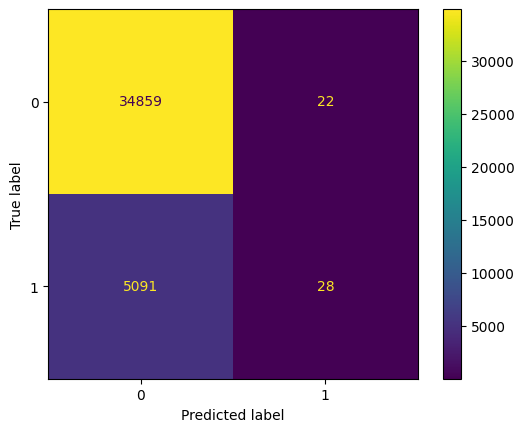

In [80]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from lightgbm import LGBMClassifier

lgbmc = LGBMClassifier(random_state=0, objective='binary', verbose=-1)
lgbmc.fit(X_train_prep, y_train)

y_pred = lgbmc.predict(X_test_prep)

print(classification_report(y_true=y_test, y_pred=y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

## With Imbalance Techniques

### Class Weighting

              precision    recall  f1-score   support

           0      0.934     0.642     0.761     34881
           1      0.220     0.691     0.334      5119

    accuracy                          0.648     40000
   macro avg      0.577     0.666     0.547     40000
weighted avg      0.843     0.648     0.706     40000



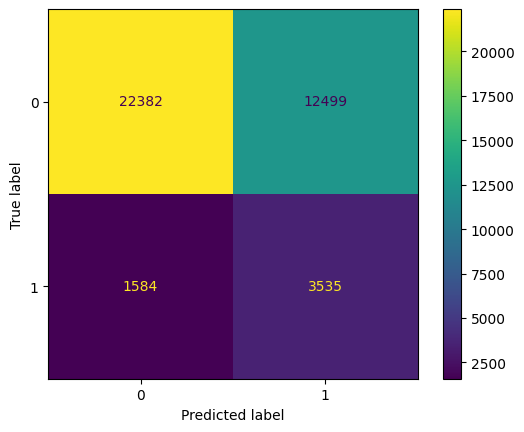

In [104]:
lgbmc_cw = LGBMClassifier(random_state=0, objective='binary', verbose=-1, class_weight='balanced')
lgbmc_cw.fit(X_train_prep, y_train)

y_pred = lgbmc_cw.predict(X_test_prep)

print(classification_report(y_true=y_test, y_pred=y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

Observations:
- As we had seen in the previous results, **the resulting model leaves much to be desired in terms of its ability to correctly detect defaults (positive class)** with a recall close to 0%, although this metric can be **raised to 70% in the model by balancing the classes by changing the class weights** during training. This improvement has been achieved **at the expense of greatly sacrificing precision** from 56% to 22% **and the ability to detect customers who have not defaulted**, from a recall for the negative class close to 100% to 64%. All this indicates that it is not possible to discriminate well between the two classes with the features present; there is a significant overlap in the probability distributions of the two classes.

- **The only notable aspect of the model would be its stability**, as the metrics are almost identical both during the model selection phase through cross-validation and in the evaluation phase with the validation set.


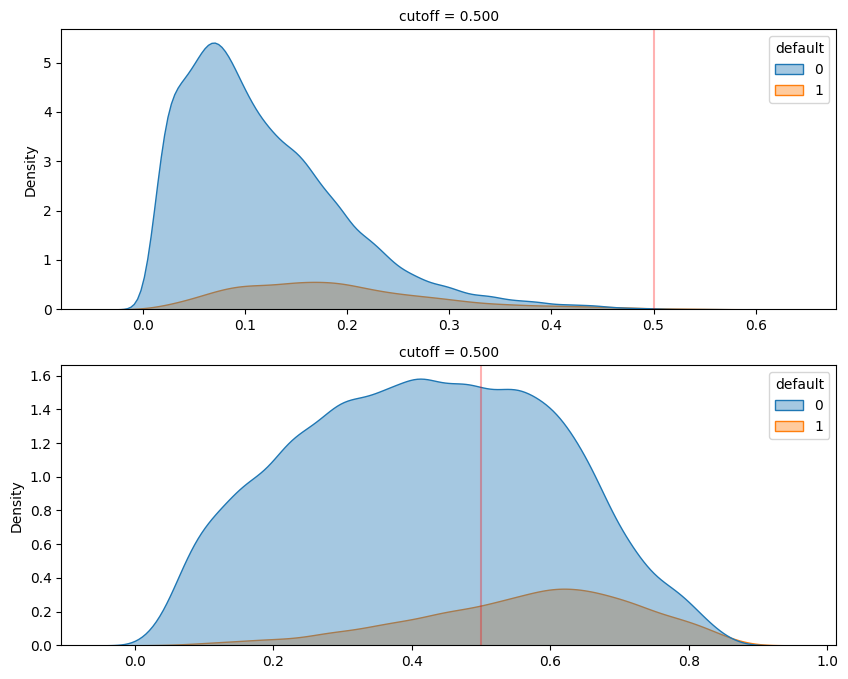

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

# Model without class weighting.
my.binary_pred_kdeplots(
    predictor=lgbmc,
    X_test=X_test_prep,
    y_test=y_test,
    prob_thresh=0.5,
    ax=ax[0]
)

# With class weighting.
my.binary_pred_kdeplots(
    predictor=lgbmc_cw,
    X_test=X_test_prep,
    y_test=y_test,
    prob_thresh=0.5,
    ax=ax[1]
)

plt.show()

Observations:
- Regarding the distribution of probability estimates of the model with default parameters and the other with balanced class weights, it is observed that **the distributions of the two classes are highly overlapping in both models, although in the model with balanced weights these distributions are more separated from each other**. We already knew that the model would have great difficulty in recognizing the 0s due to the small number of samples for that minority class and the available variables. Hence, the distribution for the 0s is more spread out.

- In this particular case, **we are interested in prioritizing the identification of customers who are likely to default** rather than the confidence, which is also important, that they have already defaulted. However, **it is not advisable to decrease the probability threshold to increase sensitivity** (recall for the positive class) since the increase in false positives would drastically decrease precision. We will leave the threshold at 0.5.


<a id=train><a />
# Save Final Model trained on Full data 

In [97]:
# Let's train the final model one last time with all the data: 200,000!
X_full = pd.read_csv('../02_Data/Original/prestamos.csv')

# Crear la target en el conjunto original:
class_neg = ["Fully Paid", "Current", "In Grace Period", "Late (16-30 days)", "Does not meet the credit policy. Status:Fully Paid"]
class_pos = ["Charged Off", "Late (31-120 days)", "Does not meet the credit policy. Status:Charged Off", "Default"]
X_full['default'] = np.where(X_full['estado'].isin(class_pos), 1, 0)

X_full['default'].value_counts(dropna=False, normalize=True)

default
0    0.872015
1    0.127985
Name: proportion, dtype: float64

In [98]:
X_train_full_prep, y_train_full, _ = preprocess_data(X_full, X_test, vars_final)

X_train_full_prep.shape, y_train_full.shape

((199764, 25), (199764,))

In [102]:
lgbmc_cw.fit(X_train_full_prep, y_train_full)
joblib.dump(value=best_lgbmc_cw, filename='../04_Models/best_lgbmc_cw_trained_all_data')

['../04_Models/best_lgbmc_cw_trained_all_data']